In [52]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix

import numpy as np
import pandas as pd
import umap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [54]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [55]:
raw_data = pd.read_csv("data/heart.csv")
original_data = raw_data.drop(columns=["target"])
training_labels = raw_data["target"]
raw_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [56]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 50, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=10, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [57]:
## Need to define a scaling function that ignores categorical values...?

In [58]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                700       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                260       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total para

In [59]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=10,
                    min_dist=0)

In [71]:
# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.2)    

pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.495, Acc:0.8686
Prediction Accuracy
25/25 [==============================] - 0s 19us/step
Scores on data set: loss=0.674 accuracy=0.7600
Fold Correct: 19
Running worker: 1
Fold: 1 -> Loss:0.486, Acc:0.8814
Prediction Accuracy
25/25 [==============================] - 0s 29us/step
Scores on data set: loss=0.466 accuracy=0.8800
Fold Correct: 22
Running worker: 2
Fold: 2 -> Loss:0.504, Acc:0.9076
Prediction Accuracy
24/24 [==============================] - 0s 27us/step
Scores on data set: loss=0.632 accuracy=0.7500
Fold Correct: 18
Running worker: 3
Fold: 3 -> Loss:0.485, Acc:0.8866
Prediction Accuracy
24/24 [==============================] - 0s 28us/step
Scores on data set: loss=0.636 accuracy=0.8750
Fold Correct: 21
Running worker: 4
Fold: 4 -> Loss:0.528, Acc:0.8529
Prediction Accuracy
24/24 [==============================] - 0s 28us/step
Scores on data set: loss=0.404 accuracy=0.9167
Fold Correct: 22
Running worker: 5
F

Confusion matrix, without normalization
[[ 90  20]
 [ 21 111]]


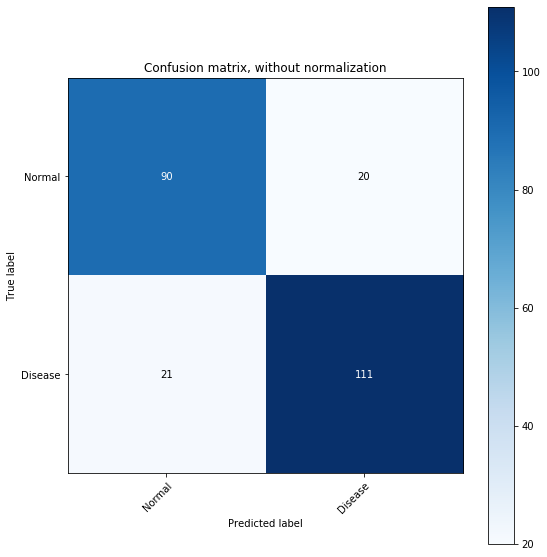

In [72]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

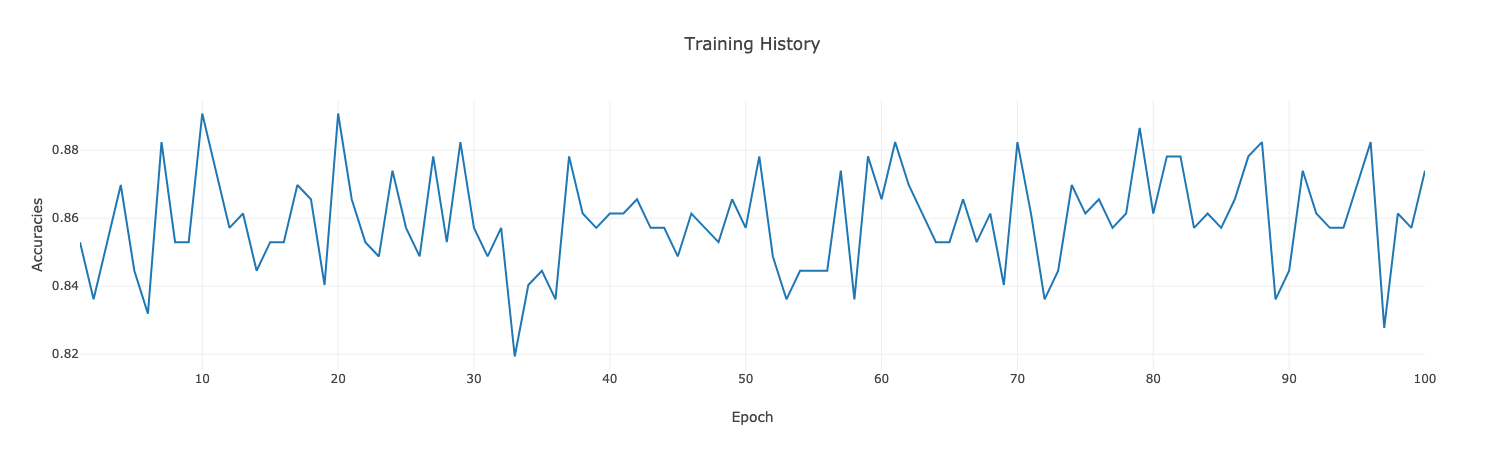

In [73]:
from plotly.offline import iplot
from plotly.offline import plot

accs = nn.history.history["acc"]
loss = nn.history.history["loss"]

accs_plot = go.Scatter(
    x=[x for x in range(1,len(accs)+1)],
    y=accs,
    mode="lines",
    name="line plot"
)

data = [accs_plot]

layout = go.Layout(
    title= "Training History",
    yaxis= {"title":"Accuracies"},
    xaxis={"title":"Epoch"}
)

fig = go.Figure(data=data, layout=layout)


iplot(fig)

In [75]:
# min_cluster_sizes=range(10,17,1)
pipeline.train_clusterer(plot=False)

Minimum Size:
Clusters                  (7, 7)
Noise                     (7, 7)
Halkidi                   (7, 7)
Halkidi-Filtered Noise    (7, 7)
dtype: object


,Clusters,Noise,Halkidi,Halkidi-Filtered Noise
"(7, 7)",4,0.0,0.158527,0.158527
"(8, 7)",4,0.0,0.158527,0.158527
"(8, 8)",4,0.0,0.158527,0.158527
"(9, 7)",4,0.0,0.158527,0.158527
"(9, 8)",4,0.0,0.158527,0.158527
"(9, 9)",4,0.0,0.158527,0.158527
"(10, 7)",4,0.0,0.158527,0.158527
"(10, 8)",4,0.0,0.158527,0.158527
"(10, 9)",4,0.0,0.158527,0.158527
"(10, 10)",4,0.0,0.158527,0.158527


In [76]:
pd.Series(pipeline.clusterer.labels_).value_counts()

1    33
3    30
0    26
2    22
dtype: int64

In [77]:
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Done!


In [78]:
pd.Series(cluster_labels).value_counts()

0    30
1     1
dtype: int64

## Plotting Testing LRP

In [79]:
training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp

In [80]:
labels = correct_pred_labels[split_class]
len(labels)

108

In [110]:
import umap
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline

embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(training_lrp)


# reducer = umap.UMAP(random_state=42,
#                     n_components = 2,
#                     n_neighbors=10,
#                     min_dist=0)

# embedding = reducer.fit_transform(training_lrp)

# emb2d = go.Scatter(
#     x=embedding[:,0],
#     y=embedding[:,1],
#     mode="markers"
# )

# layout = go.Layout(
#     title= "2D LRP Embedding"
# )

# data=[emb2d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig)



embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=5,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=pipeline.clusterer.labels_
)

val_3d_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
#         showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=800,
    paper_bgcolor='#F5F5F5'
)


data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-3d-scatter.html')